In [1]:
import pandas as pd
pd.set_option("display.notebook_repr_html", False)
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster import hierarchy
import networkx as nx
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.triads import triadic_census
import community
from community import community_louvain
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
from dcss.plotting import format_axes_commas, custom_seaborn
custom_seaborn()
import os
import pydot
import igraph as ig
import leidenalg as la




In [2]:
contact_diaries = pd.read_csv("../data/Contact-diaries-network_data_2013.csv", sep = ' ')
G = nx.from_pandas_edgelist(contact_diaries, 'i', 'j', create_using=nx.Graph)
G.name = 'Reported Contacts(Diary Data)'
print(G)
print('Number of nodes', len(G.nodes))
print('Number of edges', len(G.edges))
print('Average degree', sum(dict(G.degree).values())/len(G.nodes))

Graph named 'Reported Contacts(Diary Data)' with 120 nodes and 348 edges
Number of nodes 120
Number of edges 348
Average degree 5.8


In [3]:
contact_diaries.j.unique()[:5]

array([ 28, 106, 147, 177, 295])

In [4]:
gn_50 = nx.gn_graph(50, seed = 42)
sim_50 = pd.Series(triadic_census(gn_50))
sim_50

003     17464
012      1920
102         0
021D        0
021U      184
021C       32
111D        0
111U        0
030T        0
030C        0
201         0
120D        0
120U        0
120C        0
210         0
300         0
dtype: int64

In [5]:
gn = nx.gn_graph(20, seed = 42)
gn.name = "Simulated DiGraph with 20 nodes"
def describe_simulated_network(network):
    print(f'Network: {network.name}')
    print(f'Number of nodes: {network.number_of_nodes()}')
    print(f'Number of edges: {network.number_of_edges()}')
    print(f'Density: {nx.density(network)}')
describe_simulated_network(gn)

Network: Simulated DiGraph with 20 nodes
Number of nodes: 20
Number of edges: 19
Density: 0.05


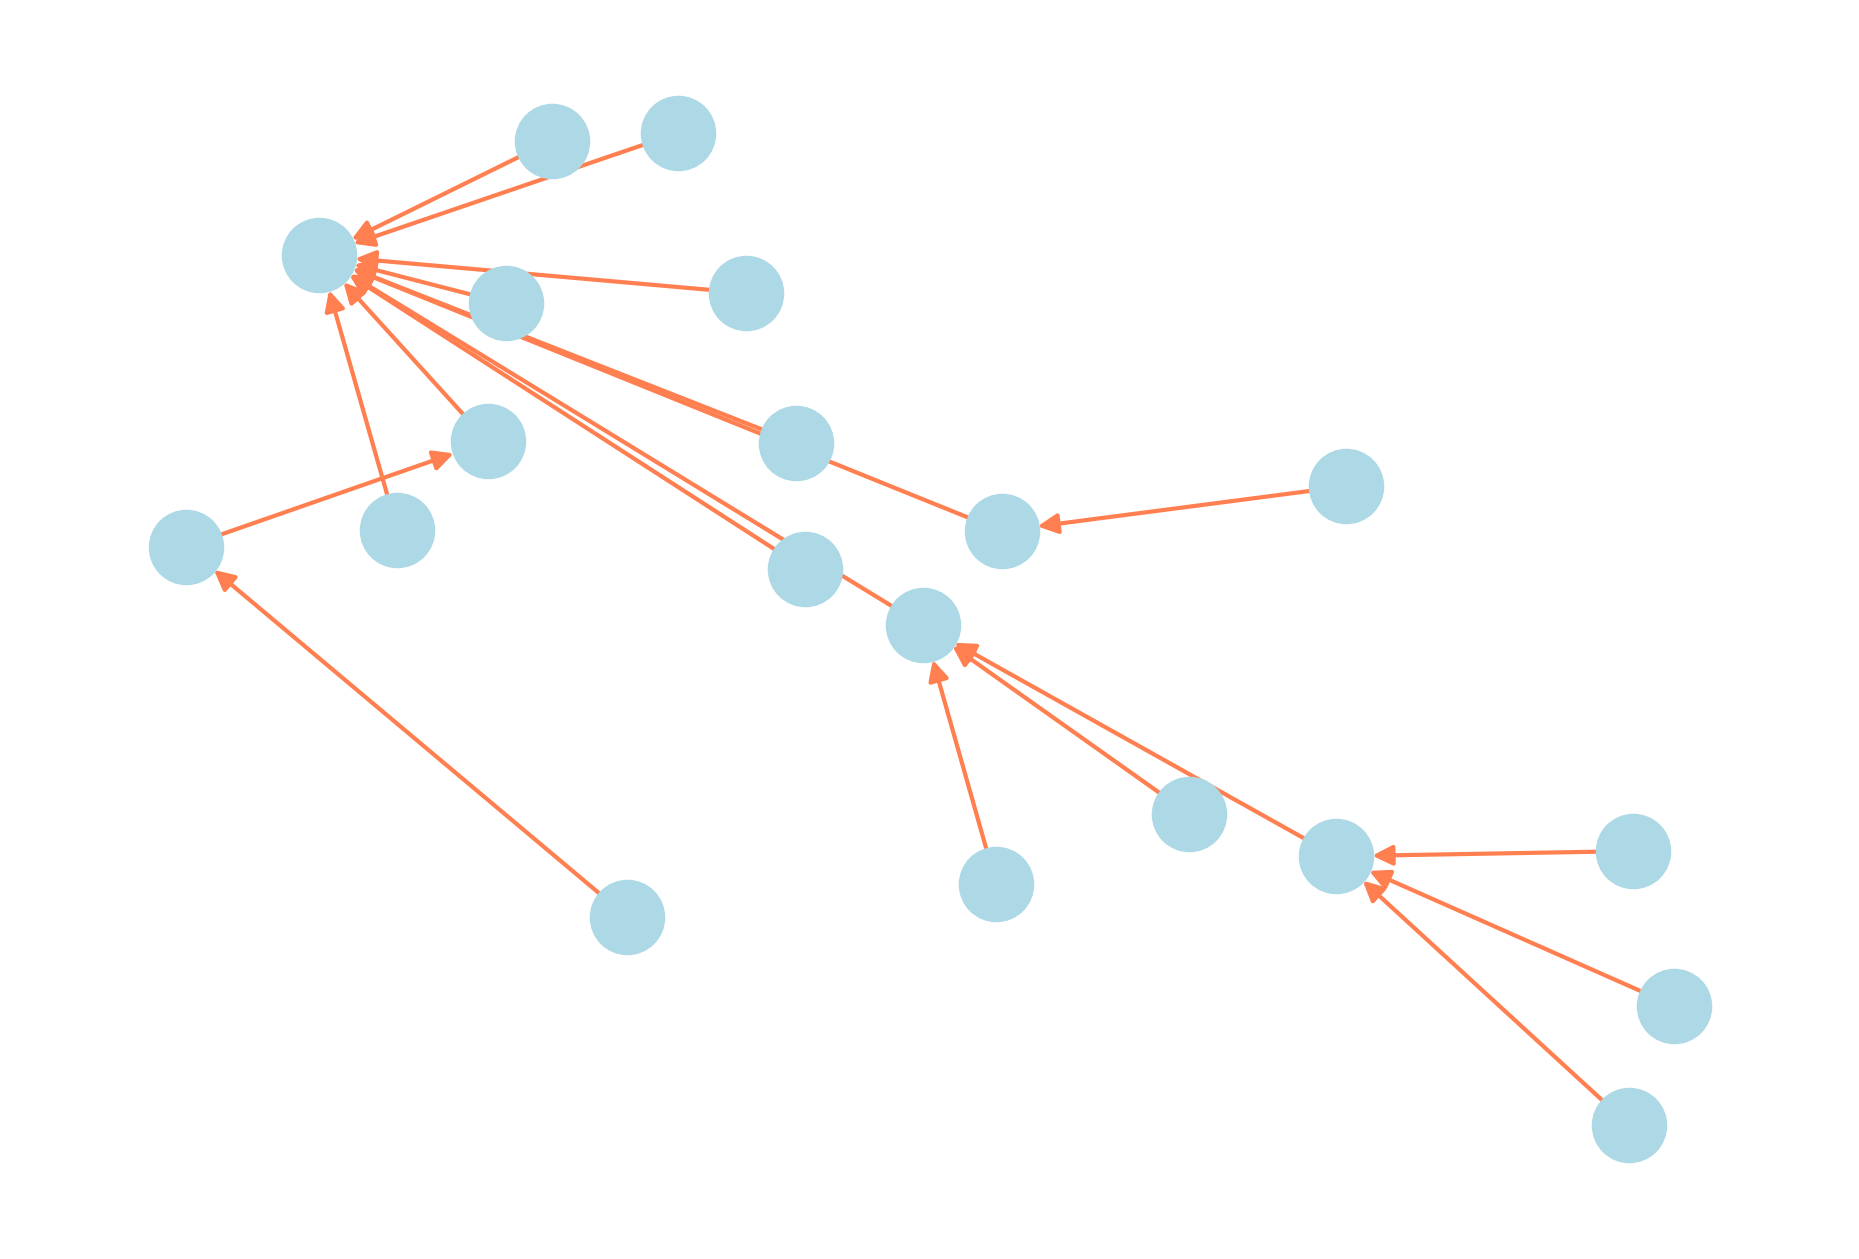

In [6]:
layout = nx.fruchterman_reingold_layout(gn, seed=12)
nx.draw(gn, layout, node_color='lightblue', edge_color='coral', node_size=300, width=1)
plt.show()

In [7]:
sim_20_a = pd.Series(triadic_census(gn))
sim_20_a

003     858
012     222
102       0
021D      0
021U     51
021C      9
111D      0
111U      0
030T      0
030C      0
201       0
120D      0
120U      0
120C      0
210       0
300       0
dtype: int64

In [8]:
gn.add_node("an isolate")
describe_simulated_network(gn)

Network: Simulated DiGraph with 20 nodes
Number of nodes: 21
Number of edges: 19
Density: 0.04523809523809524


In [9]:
sim_20_b = pd.Series(triadic_census(gn))
sim_20_b

003     1029
012      241
102        0
021D       0
021U      51
021C       9
111D       0
111U       0
030T       0
030C       0
201        0
120D       0
120U       0
120C       0
210        0
300        0
dtype: int64

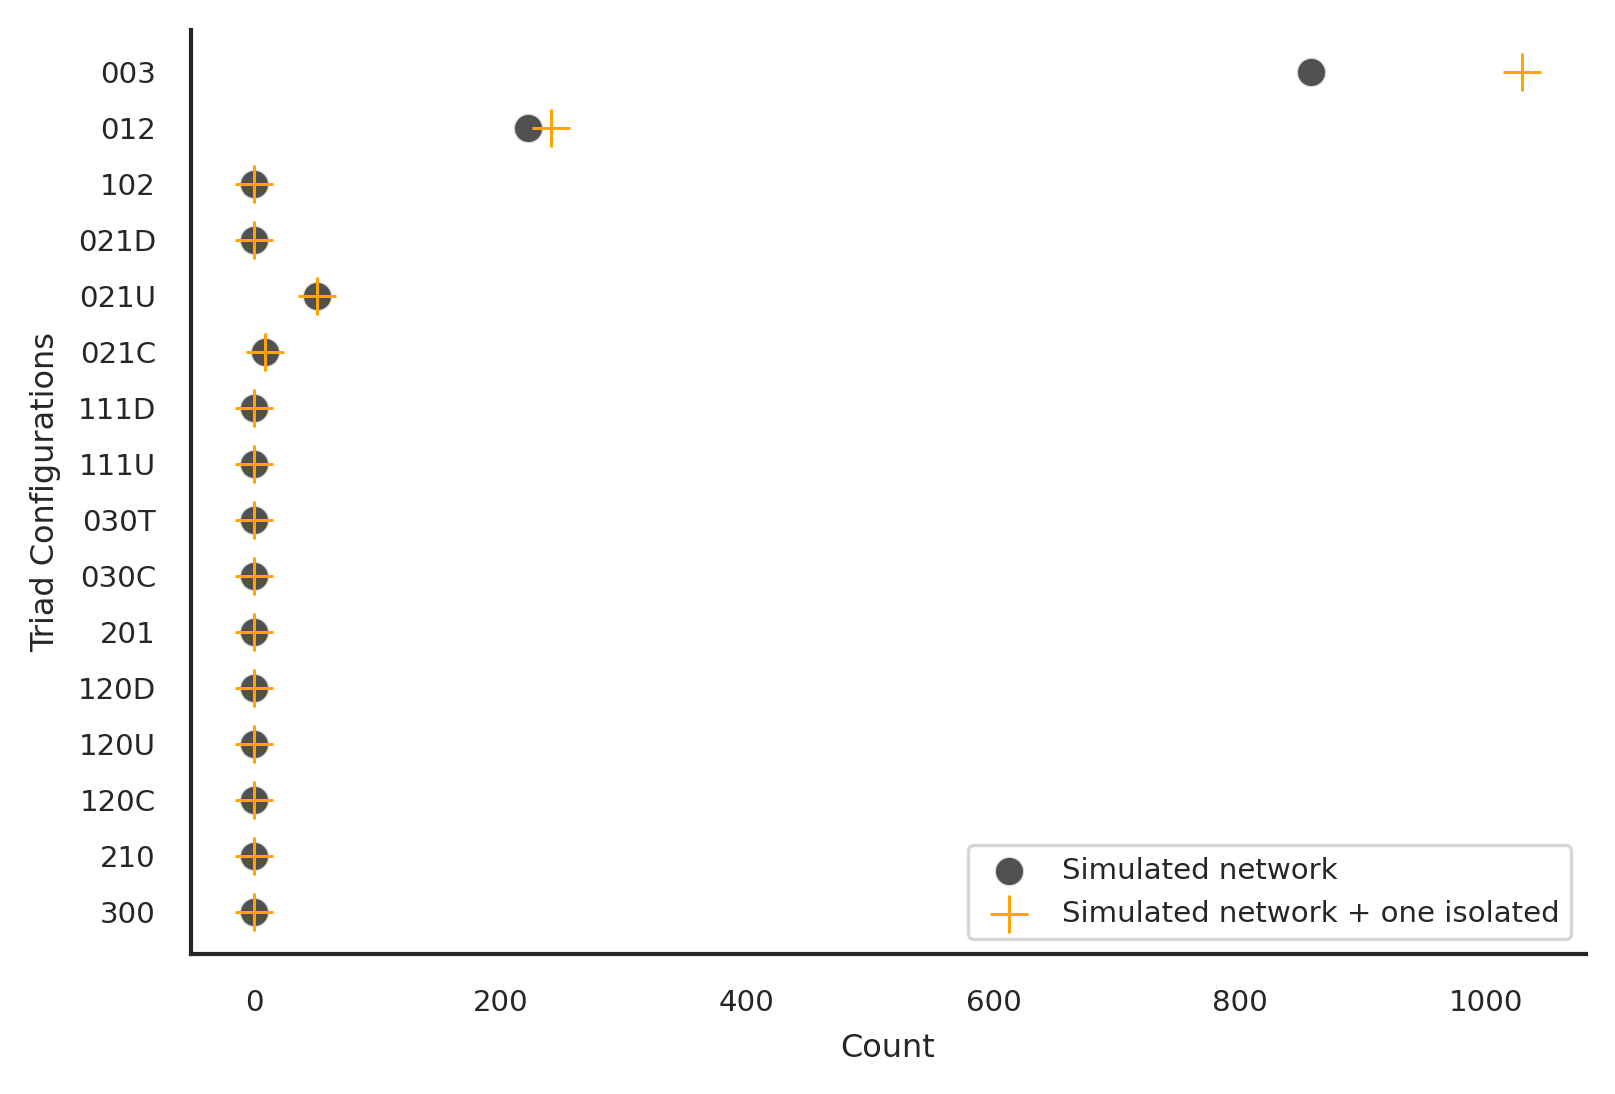

In [10]:
fig, ax = plt.subplots()
sns.scatterplot(x=sim_20_a, y=sim_20_a.index, s=50, alpha=.8, label="Simulated network")
sns.scatterplot(x=sim_20_b, y=sim_20_b.index, color='orange', marker="+", s=80, label="Simulated network + one isolated")
ax.set(xlabel='Count', ylabel='Triad Configurations')
sns.despine()
plt.legend()
plt.show()

In [11]:
clustered_g = nx.null_graph(create_using=nx.DiGraph())
nodes = range(0, 20)
for node in nodes:
    clustered_g.add_node(str(node))
for i in range(0,9):
    for j in range(0,9):
        if i!= j:
            clustered_g.add_edge(str(i), str(j))
clustered_g.name = 'Simulated DiGraph, Clustered'
describe_simulated_network(clustered_g)

Network: Simulated DiGraph, Clustered
Number of nodes: 20
Number of edges: 72
Density: 0.18947368421052632


In [12]:
not_clustered_g = nx.null_graph(create_using=nx.DiGraph())
for node in nodes:
    not_clustered_g.add_node(str(node))
for i in range(0, 72):
    random_from = str(random.randint(0, 19))
    random_to = str(random.randint(0, 19))
    while not_clustered_g.has_edge(random_from, random_to):
        random_from = str(random.randint(0, 19))
        random_to = str(random.randint(0, 19))
    not_clustered_g.add_edge(random_from, random_to)
not_clustered_g.name = 'Simulated DiGraph, Not Clustered'
describe_simulated_network(not_clustered_g)

Network: Simulated DiGraph, Not Clustered
Number of nodes: 20
Number of edges: 72
Density: 0.18947368421052632


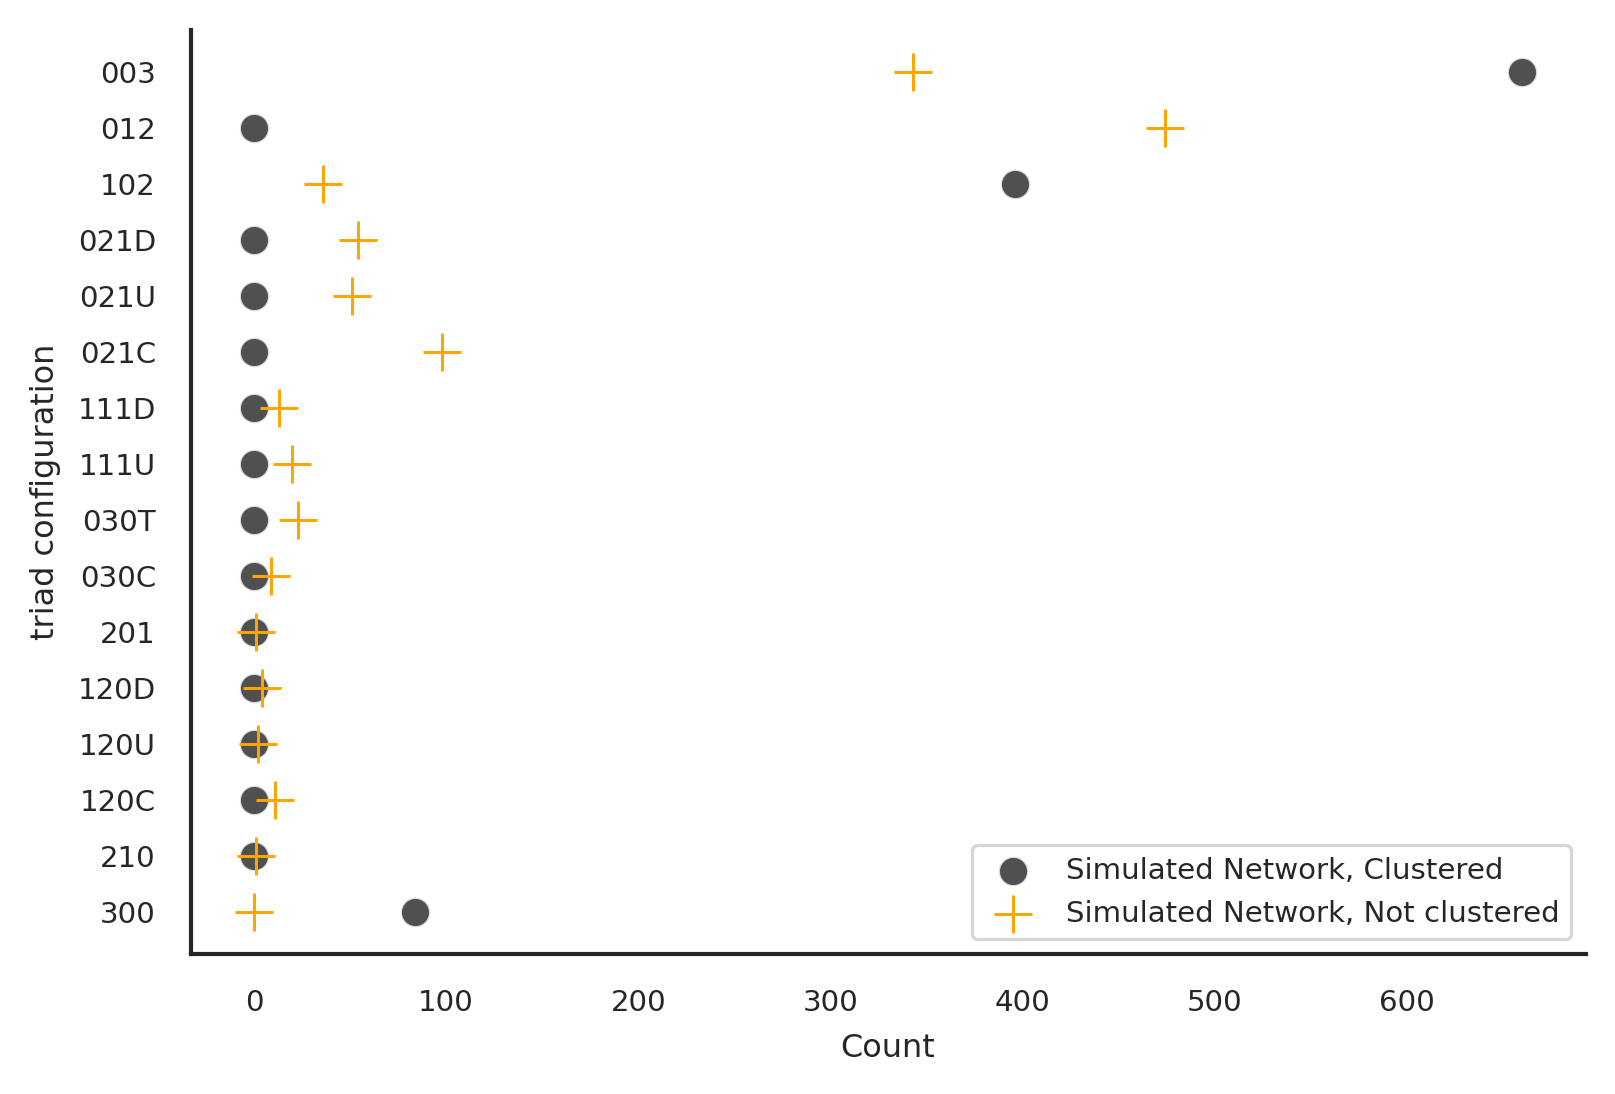

In [13]:
tc_clustered = pd.Series(triadic_census(clustered_g))
tc_not_clustered = pd.Series(triadic_census(not_clustered_g))
fig, ax =plt.subplots()
sns.scatterplot(x=tc_clustered, y=tc_clustered.index, s=50, alpha=.8, label="Simulated Network, Clustered")
sns.scatterplot(x=tc_not_clustered, y=tc_not_clustered.index, color="orange", marker="+", s=80, label="Simulated Network, Not clustered")
ax.set(xlabel='Count', ylabel='triad configuration')
sns.despine()
plt.legend()
plt.show()
fig.savefig("grafico1.png")

In [14]:
k = 5
css = list(k_clique_communities(G, k))
print(f'Identified {len(css)} {k}-clique communities.')

Identified 6 5-clique communities.


In [15]:
communities = [list(c) for c in css]
for c in communities:
    print(c)

[480, 771, 21, 791, 15]
[771, 21, 200, 826, 15]
[1828, 1412, 1295, 1201, 1594, 1214]
[232, 488, 210, 120, 89, 285]
[471, 681, 970, 475, 124]
[400, 145, 945, 489, 428]


In [16]:
kcss = {}
for node in G.nodes():
    kcliques = [communities.index(c) for c in communities if node in list(c)]
    kcss[node] = kcliques

In [17]:
overlapping_nodes = []
in_any_kclique = []
for k, v in kcss.items():
    if len(v) > 1:
        overlapping_nodes.append(k)
    if len(v) >= 1:
        in_any_kclique.append(k)
print(f'{len(overlapping_nodes)} nodes belong to multiple $k$-clique communities: {overlapping_nodes}.')
print(f'{len(in_any_kclique)} nodes ({np.round(len(in_any_kclique)/len(G), 2)+100}% of the network) are embedded in at least on $k$-clique community.')

3 nodes belong to multiple $k$-clique communities: [15, 21, 771].
29 nodes (100.24% of the network) are embedded in at least on $k$-clique community.
